# Analyse Average Pooling Results obtained from consistency data
This notebook is used to help analyse and visulise data processed from the notebook **AvgPooling3DConsistencyData.ipynb** .
Typically tasks demonstrated here are:
- plotting of score histogram
- print locations that match a consistency score criteria
- show locations in a volume that match a consistency score criteria.

## Imports and helper functions 

In [1]:
%matplotlib notebook
#Enables 3D plots to be interactive (rotation enabled)
#Comment this line if this is not required. Notebook (kernel) must also be restarted

import numpy as np
import matplotlib.pyplot as plt
import time
#import dask.array as da
import h5py
from mpl_toolkits.mplot3d import Axes3D #3D plotting

from ipywidgets import interact
import ipywidgets as widgets

In [7]:
def PadOriginalData(origdata, padindexes):
#Pads the original data by the number of indexes given
    newdatahdf5 = origdata[0][ padindexes:-padindexes , padindexes:-padindexes , padindexes:-padindexes]
    newZ= origdata[1][ padindexes:-padindexes , padindexes:-padindexes , padindexes:-padindexes]
    newY= origdata[2][ padindexes:-padindexes , padindexes:-padindexes , padindexes:-padindexes]
    newX= origdata[3][ padindexes:-padindexes , padindexes:-padindexes , padindexes:-padindexes]
    
    return (newdatahdf5 , newZ, newY, newX)

In [12]:
def GetIndicesFromOrigDataWithConsistencyScoreBetween(datatuple, cscore_low, cscore_high):
    ''' Get indices of original data where the consistency score is betwen cscore_low and cscore_high
    datatuple must be in format
        datatuple[0] : array with the results of the average pooling
        datatuple[1] , [2], [3] : Z,Y,X coordinates of the original data from where the average pooling was performed (corner?)
    '''
    
    #This is needed to prevent errors when using slider (native Python float values to numpy.float)
    cscore_low_np = np.float64(cscore_low)
    cscore_high_np = np.float64(cscore_high)
    
    data = datatuple[0]

    indexes = np.where( (data >= cscore_low_np) & (data <= cscore_high_np ) )
    #Values will be in format (example)
    # (array([52, 53, 54, 55, 56]), array([0, 0, 0, 0, 0]), array([283, 283, 283, 283, 283]))
    
    #Convert these indices to the original data indices
    i_zip = list(zip(indexes[0],indexes[1],indexes[2]))
    #This will convert to format (example)
    # [(52, 0, 283), (53, 0, 283), (54, 0, 283), (55, 0, 283), (56, 0, 283)]
    
    #print (i_zip)
    i_conv=[]
    #Convert indices to ones from original data
    for e1 in i_zip:
        #print (e1)
        iz = datatuple[1][ e1[0] , e1[1] , e1[2] ]
        iy = datatuple[2][ e1[0] , e1[1] , e1[2] ]
        ix = datatuple[3][ e1[0] , e1[1] , e1[2] ]

        i_conv.append( (iz,iy,ix))

    return i_conv

def GetIndicesFromOrigDataWithConsistencyScoreNear(datatuple, cscore, cwidth= 0.1):
    ''' Get indices of original data where the consistency score is between
    cscore-cwidth and and cscore-cwidth
    datatuple must be in format
        datatuple[0] : array with the results of the average pooling
        datatuple[1] , [2], [3] : Z,Y,X coordinates of the original data from where the average pooling was performed (corner?)
    '''
    cscore_low = cscore-cwidth/2
    cscore_high = cscore+cwidth/2
    
    return GetIndicesFromOrigDataWithConsistencyScoreBetween(datatuple, cscore_low, cscore_high)

In [15]:
def PlotZYXPointFromList(points3Dlist):
    #Function to visualise location 3D points from a list of coordinates given
    
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111, projection='3d')
    
    for p0 in points3Dlist:
        ax.scatter(p0[2], p0[1], p0[0], marker = ',', color='blue')
    ax.set_xlabel('X index')
    ax.set_ylabel('Y index')
    ax.set_zlabel('Z index')

In [18]:
def PlotRegionsWhereRelatScoreConsistencyIs(relvalue0to1 , relwidth=0.1 , bPrintIndexes=False):
    ''' Plots 3D locations in a volume, where the Relative score consistency is between
    relvalue0to1-relwidth and relvalue0to1-relwidth
    
    bPrintIndexes: prints 3D locations found within the score region
    
    This function is designed to be used with interactivity in plots.
    Global variables origdata, minValue and maxValue must be predefined
    '''
    
    abs_value = minValue + relvalue0to1*(maxValue-minValue)
    abs_precis_width = relwidth *(maxValue-minValue)
    print ("abs_value =", abs_value , ", abs_precis_width=", abs_precis_width)
    listofindexes= GetIndicesFromOrigDataWithConsistencyScoreNear(origdata, abs_value, abs_precis_width )
    PlotZYXPointFromList(listofindexes)
    if bPrintIndexes:
        print (listofindexes)
    
def PlotRegionsWhereScoreConsistencyIsBetween(value_low , value_high, bPrintIndexes=False):
    ''' Plots 3D locations in a volume, where the score consistency is between
    value_low and value_high
    
    bPrintIndexes: prints 3D locations found within the score region
    
    This function is designed to be used with interactivity in plots.
    Global variables origdata, minValue and maxValue must be predefined
    '''
    listofindexes= GetIndicesFromOrigDataWithConsistencyScoreBetween(origdata, value_low, value_high )
    PlotZYXPointFromList(listofindexes)
    if bPrintIndexes:
        print (listofindexes)

## Loading data

In [2]:
#Type the correct filename here
f = h5py.File('2020-04-09_final_4_volumes_combined_VolAvg_k256_s128.h5','r')
print ("file details")
list (f.keys())

file details


['X', 'Y', 'Z', 'data']

In [3]:
datahdf5 =  f['data']
print (datahdf5.shape)
X = f['X']
Y = f['Y']
Z = f['Z']
origdata= (datahdf5, Z , Y, X) #Keep average pooling data and corresponding indexes together in this tuple

(15, 18, 18)


In [6]:
#Find minimum and maximum values indices
#These values will be useful later
minValue = np.amin(datahdf5)
maxValue = np.amax(datahdf5)
print("minValue=", minValue)
print("maxValue=", maxValue)

minValue= 15.479485034942627
maxValue= 35.796614587306976


## Analysis

### Histogram of consistency scores

In [4]:
#histogram of intensities
datahdf5_hist, binsedge = np.histogram(datahdf5 , bins='auto')

<IPython.core.display.Javascript object>


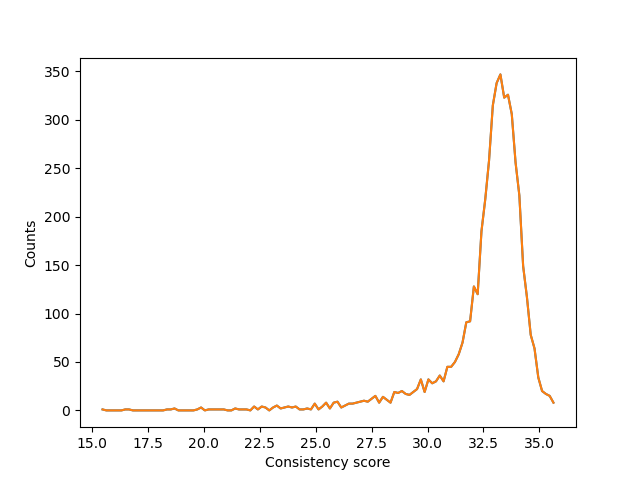

Text(0, 0.5, 'Counts')

In [5]:
plt.plot(binsedge[:-1],datahdf5_hist)
plt.xlabel('Consistency score')
plt.ylabel('Counts')

### Padding data example

In [8]:
paddeddata = PadOriginalData(origdata,2) # pad data by n indexes, to avoid borders

In [9]:
#histogram of intensities
paddeddata_hist, binsedge = np.histogram(datahdf5 , bins='auto')

In [10]:
plt.plot(binsedge[:-1],paddeddata_hist)
plt.xlabel('Consistency score')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

In [11]:
#Find minimum and maximum values indices
minValuePad = np.amin(paddeddata[0])
maxValuePad = np.amax(paddeddata[0])
print("minValuePad=", minValue)
print("maxValuePad=", maxValue)

minValuePad= 15.479485034942627
maxValuePad= 35.796614587306976


### Extracting indexes (text)

In [13]:
print("Indices at minimum value")
print(GetIndicesFromOrigDataWithConsistencyScoreNear(origdata, minValue))

Indices at minimum value
[(512, 128, 2304)]


In [14]:
print("Indices at 1/4 score value = ", str((maxValue-minValue)*0.25+minValue )  )
listof_IndexQuarters = GetIndicesFromOrigDataWithConsistencyScoreNear(origdata, (maxValue-minValue)*0.25+minValue,0.1 )
print( listof_IndexQuarters )

Indices at 1/4 score value =  20.558767423033714
[(1920, 1664, 256)]


### 3D plots of score indexes locations

<IPython.core.display.Javascript object>


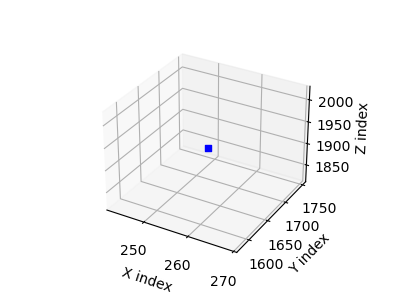

In [16]:
PlotZYXPointFromList(listof_IndexQuarters)

<IPython.core.display.Javascript object>


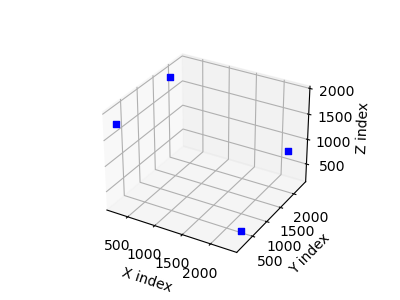

In [17]:
listof_IndexHalfs = GetIndicesFromOrigDataWithConsistencyScoreNear(origdata, (maxValue-minValue)*0.5+minValue ,0.1)
PlotZYXPointFromList(listof_IndexHalfs)

Plot with slider

abs_value = 17.511197990179063 , abs_precis_width= 2.031712955236435


<IPython.core.display.Javascript object>


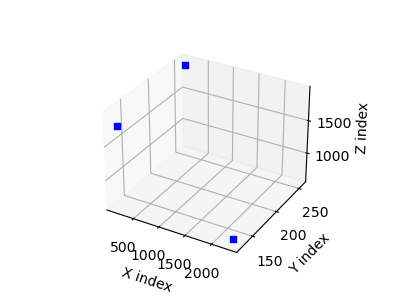

In [19]:
PlotRegionsWhereRelatScoreConsistencyIs(0.1)

abs_value = 25.6380498111248 , abs_precis_width= 2.031712955236435


<IPython.core.display.Javascript object>


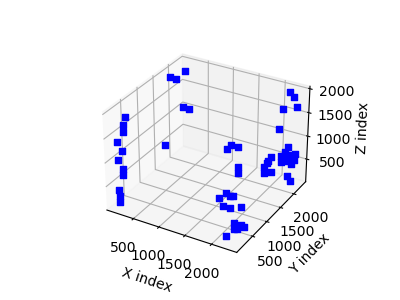

In [20]:
PlotRegionsWhereRelatScoreConsistencyIs(0.5)

abs_value = 31.733188676834107 , abs_precis_width= 2.031712955236435


<IPython.core.display.Javascript object>


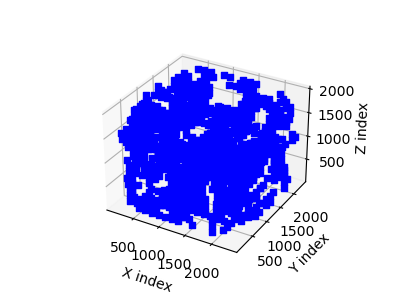

In [21]:
PlotRegionsWhereRelatScoreConsistencyIs(0.8)

<IPython.core.display.Javascript object>


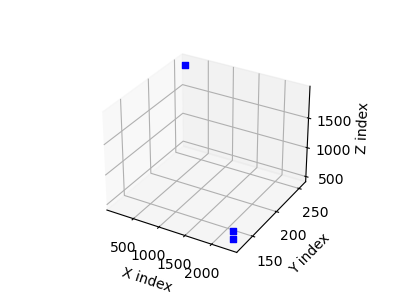

In [22]:
PlotRegionsWhereScoreConsistencyIsBetween(minValue , minValue+2.0)

### Interactive 3D plots of score indexes locations

In [25]:
interact(PlotRegionsWhereScoreConsistencyIsBetween, \
         value_low = widgets.FloatSlider(value=minValue, min=minValue, max=maxValue , continuous_update=False ) , \
         value_high = widgets.FloatSlider(value= (minValue+0.1), min=minValue, max=maxValue , continuous_update=False )
        )

interactive(children=(FloatSlider(value=15.479485034942627, continuous_update=False, description='value_low', …

<function __main__.PlotRegionsWhereScoreConsistencyIsBetween(value_low, value_high, bPrintIndexes=False)>

In [24]:
interact(PlotRegionsWhereRelatScoreConsistencyIs, \
         relvalue0to1 = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.01 , continuous_update=False ) , \
         relwidth = widgets.FloatSlider(value= 0.1, min=0.0, max=0.5,step=0.025, continuous_update=False )
        )

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='relvalue0to1', max=1.0, ste…

<function __main__.PlotRegionsWhereRelatScoreConsistencyIs(relvalue0to1, relwidth=0.1, bPrintIndexes=False)>